In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os, time, datetime, shutil, json
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
import shap
import datetime
from sklearn.datasets import make_hastie_10_2
import logging
import sys
import conifer
from scipy.special import expit

In [36]:
os.environ['XILINX_AP_INCLUDE'] = '/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/HLS_arbitrary_Precision_Types/include'
os.environ['XILINX_HLS'] = os.environ['XILINX_AP_INCLUDE']
os.environ["CXXFLAGS"] = f"-I{os.environ['XILINX_AP_INCLUDE']}"
plots_dir = "plots"

In [3]:
# File paths for signal and background root files: 
electron_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200gen_filtered.h5"
electron_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/ElectronPU200cl3d_filtered.h5"
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200gen_filtered.h5"
photon_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonsPU200cl3d_filtered.h5"
qcdPU200_df = pd.read_hdf("/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/output_matched.h5", key="matched")
neutrino_PU200_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/cl3d_filtered_neutrino.h5"
neutrino_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/gen_filtered_neutrino.h5"
pions200PU_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200gen_filtered.h5"
pions200PU_cl3d = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PionsPU200cl3d_filtered.h5"

In [4]:
photonPU200_df = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d)
neutrinoPU200_df = ana.load_and_filter_hdf('None', neutrino_PU200_cl3d)

In [5]:
pionsPU200_df = ana.load_and_filter_hdf(pions200PU_gen, pions200PU_cl3d)

In [6]:
photonPU200_df_filtered = ana.filter_by_delta_r(photonPU200_df)

In [7]:
photonPU200_df_filtered

,event,gen_n,gen_eta,gen_phi,gen_pt,genpart_exphi,genpart_exeta,cl3d_n,cl3d_id,cl3d_pt,...,cl3d_ebm0,cl3d_ebm1,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,delta_r
0,963,2,1.605055,1.870481,77.166519,1.870476,1.619583,233,3005032260,71.626648,...,8188,4080,0,10.353609,31.868980,0.998194,3,78.843399,206.991058,0.000612
1,964,2,-2.293216,-2.008300,37.492821,-2.008323,-2.297131,176,3123090449,39.634224,...,8188,2040,1179648,9.964572,33.061501,0.996998,3,38.088108,191.775681,0.002964
2,967,2,-2.642445,2.534270,95.656731,2.534266,-2.667950,141,3123466596,102.855354,...,8191,2046,2129920,11.126816,45.764435,0.998573,3,98.080032,708.244019,0.002758
3,973,2,2.660396,-2.199382,78.736244,-2.199376,2.664191,185,2988859429,90.908417,...,8191,4092,3448832,13.832698,54.801208,0.993899,3,85.446091,613.929321,0.004561
4,976,2,2.081906,0.016363,63.450912,0.016359,2.084343,151,2996573492,64.350174,...,8190,4088,0,11.352663,39.784458,0.998573,3,66.714264,272.540863,0.000853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26363,299981,2,2.528172,2.382890,42.980457,2.382893,2.510117,231,2987680850,50.873444,...,8189,4080,3604480,14.751777,58.590382,0.983090,3,49.308468,305.821991,0.008527
26364,299991,2,2.301080,-0.435585,28.195385,-0.435576,2.292806,183,2988856595,32.157192,...,8189,2032,3145728,9.741532,39.659142,0.992695,3,31.118126,155.736298,0.001510
26365,299992,2,2.695126,-0.928240,20.297224,-0.928248,2.685960,212,2988864343,30.011381,...,8190,4064,264192,18.357073,62.477238,-0.978804,0,26.663443,193.962921,0.015910
26366,299994,2,2.029385,-0.861808,22.579664,-0.861812,2.021904,235,2997270069,24.885330,...,8191,2032,2097152,8.583792,28.965210,0.998573,3,23.955429,92.112068,0.003844


In [8]:
qcdPU200_df

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_hbm,cl3d_ntc67,cl3d_ntc90,cl3d_bdteg,cl3d_quality,cl3d_ipt,cl3d_ienergy,base_weight,flat_weight,delta_r
634,4035652,325,7.691325,-3.140248,0.236373,258.742523,22,1,2.974360,-2.326480,...,65536,32.357422,65.598808,-0.979485,0,0.000000,0.000000,33333.333333,3.912940e+05,0.331608
635,4035652,325,7.691325,-3.140248,0.236373,258.742523,22,1,2.974360,-2.326480,...,65536,32.357422,65.598808,-0.979485,0,20.213856,99.310417,33333.333333,3.912940e+05,0.331608
13508,4143812,677,5.386865,-0.855794,0.088273,9.644744,22,1,0.282039,2.277560,...,3145728,0.819642,7.635280,-0.998923,0,0.000000,0.000000,33333.333333,3.912940e+05,0.389790
13509,4143812,677,5.386865,-0.855794,0.088273,9.644744,22,1,0.282039,2.277560,...,3145728,0.819642,7.635280,-0.998923,0,35.248039,242.769287,33333.333333,3.912940e+05,0.389790
13522,4143812,677,1.580791,1.648170,0.155787,0.394501,22,1,0.383395,2.833086,...,3145728,0.819642,7.635280,-0.998923,0,0.000000,0.000000,33333.333333,3.912940e+05,0.233318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137520031,241229,802,-5.702281,0.267538,0.143995,21.567146,22,1,-0.509763,1.942878,...,3276800,43.777573,98.734444,-0.704127,2,79.582848,283.850311,13658.536585,1.603351e+05,0.055627
137520032,241229,802,1.949083,-0.526157,7.358253,26.359659,22,1,-0.444758,1.946242,...,3276800,43.777573,98.734444,-0.704127,2,0.000000,0.000000,13658.536585,1.603351e+05,0.120620
137520033,241229,802,1.949083,-0.526157,7.358253,26.359659,22,1,-0.444758,1.946242,...,3276800,43.777573,98.734444,-0.704127,2,79.582848,283.850311,13658.536585,1.603351e+05,0.120620
137520034,241229,802,1.949901,-0.538724,15.612135,55.971661,22,1,-0.496949,1.944530,...,3276800,43.777573,98.734444,-0.704127,2,0.000000,0.000000,13658.536585,8.110867e+06,0.068417


In [9]:
neutrinoPU200_df_filtered= neutrinoPU200_df[neutrinoPU200_df['cl3d_pt'] > 20]

In [10]:
qcdPU200_df['label'] = 0
photonPU200_df_filtered['label'] = 1
pionsPU200_df['label'] = 2
neutrinoPU200_df_filtered['label'] = 3 

/tmp/ipykernel_2222982/671892702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutrinoPU200_df_filtered['label'] = 3


In [11]:
columns_for_training = [
     'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 
     'cl3d_eot', 'cl3d_firstHcal5layers', 'cl3d_first5layers', 
     'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_meanz', 
     'cl3d_last5layers', 'cl3d_emax5layers', 
     'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm'
] 

var_latex_map = {
    'cl3d_emax1layers': 'Emax1layers',
    'cl3d_emax3layers': 'Emax3layers',
    'cl3d_emax5layers': 'Emax5layers',
    'cl3d_showerlength': 'Shower Length',
    'cl3d_coreshowerlength': 'Core Shower Length',
    'cl3d_firstlayer': 'First Layer',
    'cl3d_hoe': 'CE-H/CE-E',
    'cl3d_varrr': '$\sigma^2_{rr}$',
    'cl3d_varzz': '$\sigma^2_{zz}$',
    'cl3d_varee': '$\sigma^2_{\eta\eta}$',
    'cl3d_varpp': '$\sigma^2_{\phi\phi}$',
    'cl3d_meanz': '<z>',
    'cl3d_first1layers': 'First1layer',
    'cl3d_first3layers': 'First3layers',
    'cl3d_first5layers': 'First5layers',
    'cl3d_firstHcal1layers': 'FirstHcal1layer',
    'cl3d_firstHcal3layers': 'First Hcal3layers',
    'cl3d_firstHcal5layers': 'First Hcal5layers',
    'cl3d_last1layers': 'Last1layer',
    'cl3d_last3layers': 'Last3layers',
    'cl3d_last5layers': 'Last5layers',
    'cl3d_ebm0' : 'EBM0', 
    'cl3d_ebm1' : 'EBM1',
    'cl3d_hbm' : 'HBM',
    'cl3d_eot' : 'E/Total E'
}

In [12]:
all_dfs = [qcdPU200_df, photonPU200_df_filtered, pionsPU200_df, neutrinoPU200_df_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][columns_for_training + ['label']]

In [13]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [14]:
X = df_combined[columns_for_training]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [15]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [16]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [17]:
model.fit(X_train, y_train, sample_weight=w_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [18]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2, 3]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.917
🔢 Confusion Matrix:
 [[32937  1479   288  1945]
 [  116  5137     0    21]
 [  410    40 29026  1364]
 [  459   130   187  3785]]
📈 ROC AUC (OvR): 0.986


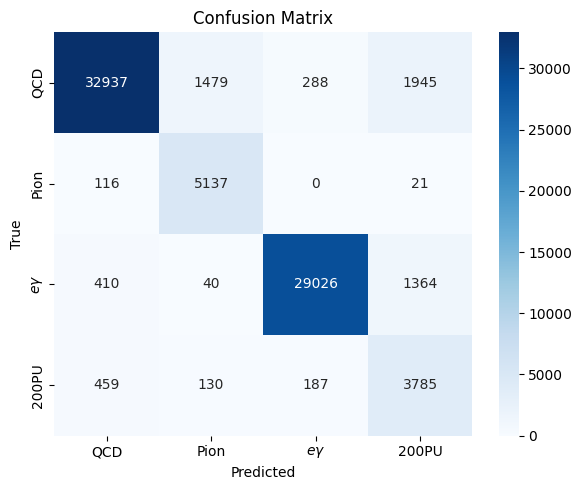

In [ ]:
class_names = ['QCD', 'Pion', '$\gamma$', '200PU']
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

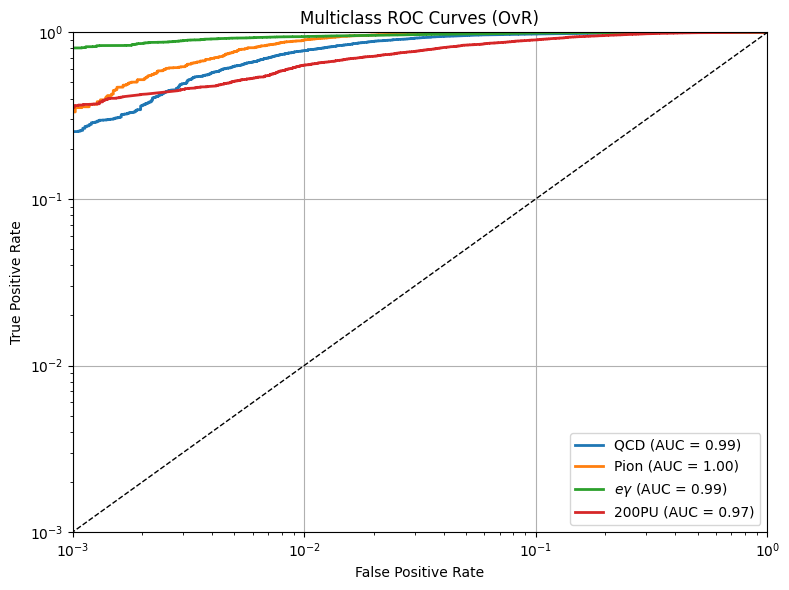

In [20]:
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.001, 1.0])
plt.ylim([0.001, 1.0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (OvR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multiclass_roc.png", dpi=300)
plt.show()

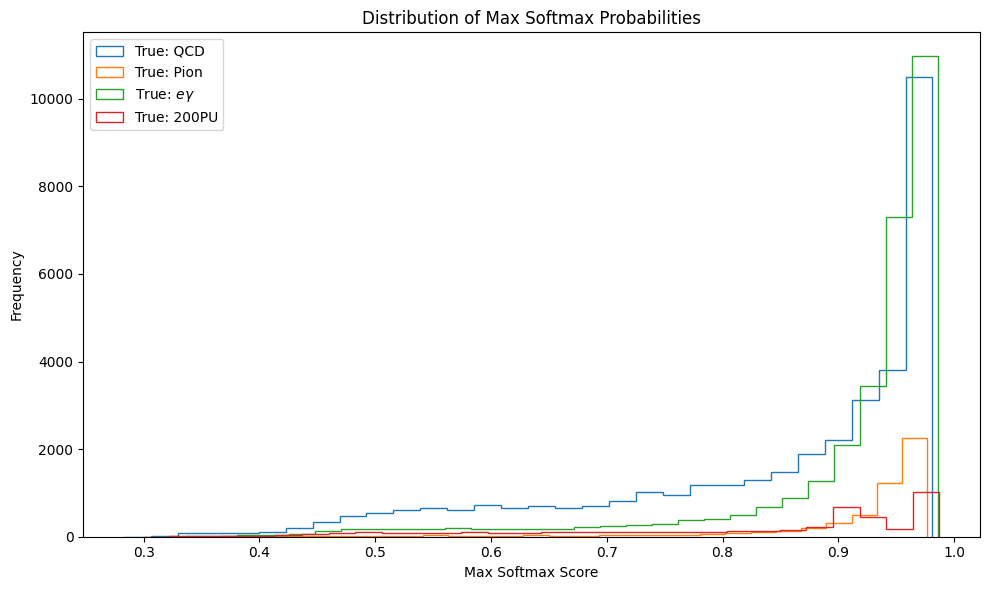

In [21]:
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.hist(y_pred_proba[y_test == i].max(axis=1), bins=30, histtype = 'step', label=f"True: {class_names[i]}")
plt.xlabel("Max Softmax Score")
plt.ylabel("Frequency")
plt.title("Distribution of Max Softmax Probabilities")
plt.legend()
plt.tight_layout()
plt.savefig("softmax_distribution.png", dpi=300)
plt.show()

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

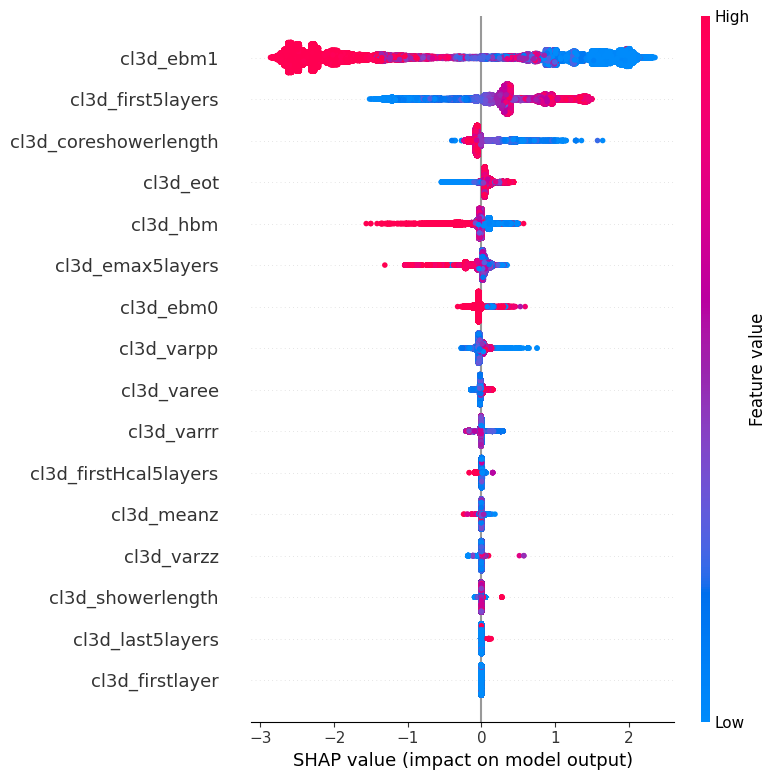

In [23]:
shap_vals_pion = shap_values[:, :, 2]
shap.summary_plot(shap_vals_pion, X_test, feature_names=columns_for_training, show=True)

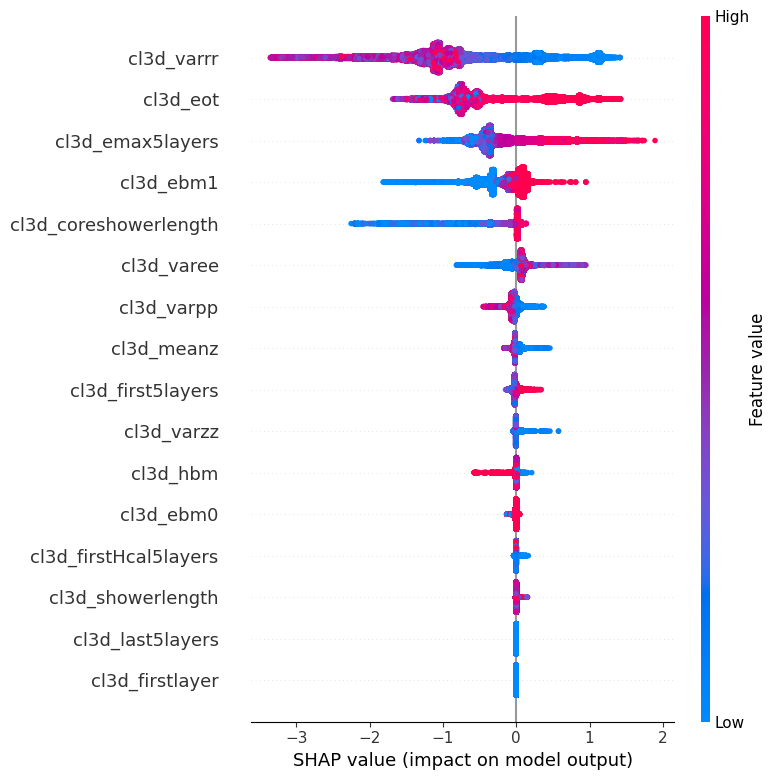

In [24]:
shap_vals_egamma = shap_values[:, :, 1]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=columns_for_training, show=True)

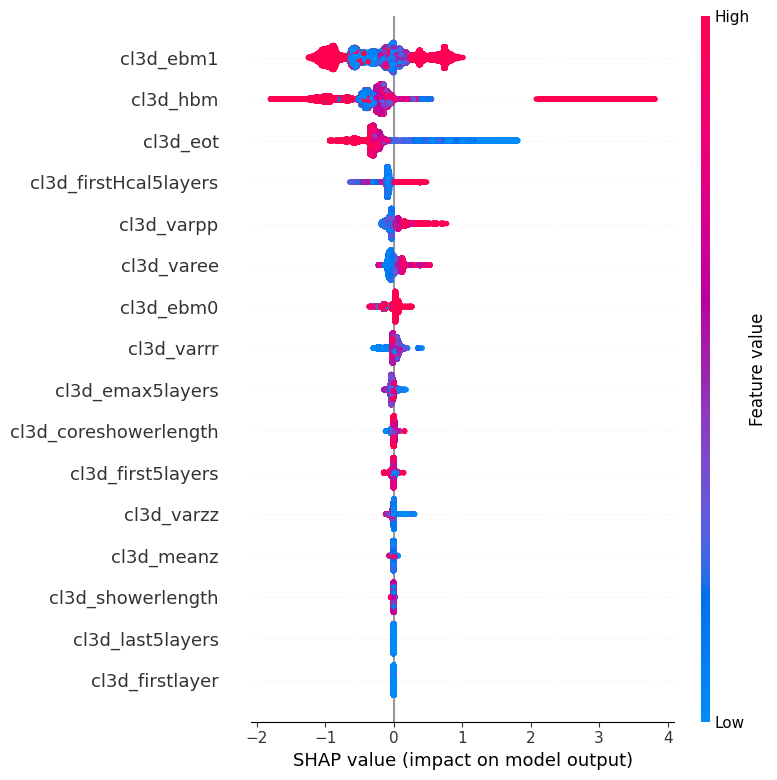

In [25]:
shap_vals_pu = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pu, X_test, feature_names=columns_for_training, show=True)

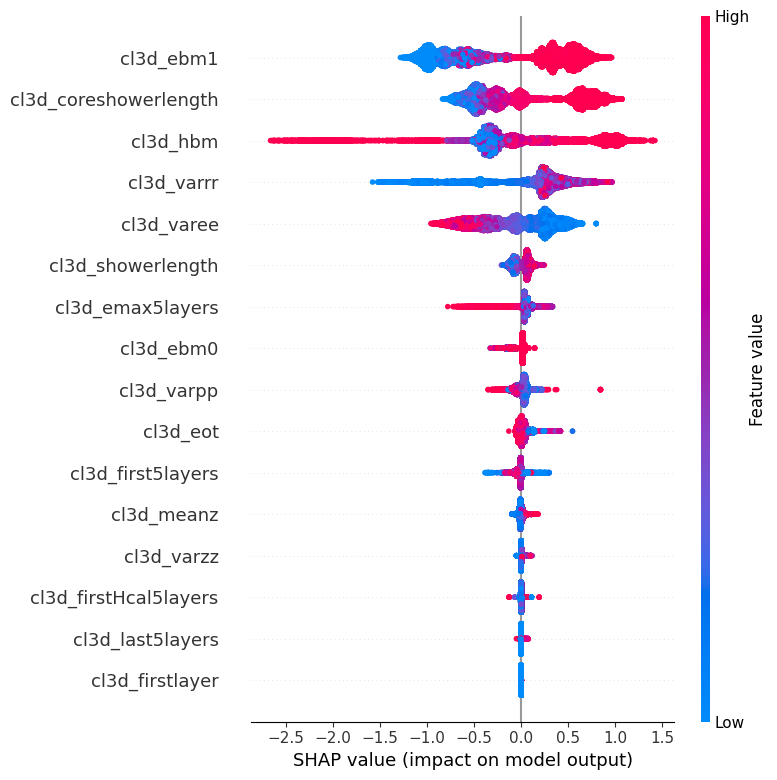

In [26]:
shap_vals_qcd = shap_values[:, :, 0]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=columns_for_training, show=True)

In [34]:
results = []
base_dir = os.getcwd()

def train_quantized_multiclass(precision, depth, rounds, iteration, X_train, y_train, X_test, y_test):
    timer = time.time()
    print(f"[{iteration}] Training model: precision={precision}, depth={depth}, rounds={rounds}")

    # Step 1: Quantization
    qtrain = pd.DataFrame()
    qtest = pd.DataFrame()
    for feat in X_train.columns:
        fmin, fmax = X_train[feat].min(), X_train[feat].max()
        qtrain[feat] = ana.quantize(X_train[feat], precision, 'uniform', fmin, fmax)
        qtest[feat] = ana.quantize(X_test[feat], precision, 'uniform', fmin, fmax)

    # Step 2: Normalize
    max_range = 1 - 1 / (2 ** precision)
    scaler = MinMaxScaler(feature_range=(0, max_range))
    qtrain_scaled = pd.DataFrame(scaler.fit_transform(qtrain), columns=X_train.columns)
    qtest_scaled = pd.DataFrame(scaler.transform(qtest), columns=X_test.columns)

    # Step 3: XGBoost Training
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        max_depth=depth,
        n_estimators=rounds,
        learning_rate=0.05,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_jobs=8,
        verbosity=0
    )
    model.fit(qtrain_scaled, y_train)

    pred_probs = model.predict_proba(qtest_scaled)
    y_pred = np.argmax(pred_probs, axis=1)

    acc = (y_pred == y_test).sum() / len(y_test)
    macro_auc = roc_auc_score(y_test, pred_probs, multi_class='ovo')

    # Step 4: Conifer Config
    cfg = conifer.backends.xilinxhls.auto_config()
    path = f"hdlprojects/prj_vhdl_multiclass_{precision}_{depth}_{rounds}_{iteration}"
    if os.path.exists(path):
        ana.remove_folder(path)
    cfg['OutputDir'] = path
    cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'
    cfg['Precision'] = f"ap_fixed<{precision},0>"
    cfg['ClockPeriod'] = 3
    cfg['ProjectName'] = 'hgcal_multiclass'

    # Step 5: Conifer Conversion & Synthesis
    from conifer import model as conifer_model

    cnf_model = conifer.converters.convert_from_xgboost(model.get_booster(), cfg)
    cnf_model.compile()
    y_hdl = expit(cnf_model.decision_function(qtest_scaled))
    cnf_model.build(csim=True)

    # LUT Extraction
    report_path = os.path.join(cfg['OutputDir'], 'util.rpt')
    with open(report_path, 'r') as f:
        lines = f.readlines()
        LUT = int(lines[37].split('|')[2])

    duration = time.time() - timer
    print(f"Finished Iter {iteration}: Accuracy={acc:.4f}, AUC={macro_auc:.4f}, LUT={LUT}, Time={duration:.2f}s")

    os.chdir(base_dir)
    return (precision, depth, rounds, acc, macro_auc, LUT)

In [37]:
result_table = pd.DataFrame(columns=["precision", "depth", "rounds", "acc", "auc", "LUT"])

# Loop
iteration = 0
for prec in [12]:       # choose precision range
    for depth in [3, 4, 5]:             # max tree depth
        for rounds in [10, 20, 40]:     # number of boosting rounds
            row = train_quantized_multiclass(prec, depth, rounds, iteration, X_train, y_train, X_test, y_test)
            result_table.loc[len(result_table)] = row
            result_table.to_csv("conifer_multiclass_opti.csv", index=False)
            iteration += 1

[0] Training model: precision=12, depth=3, rounds=10


/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
bridge.cpp:3:10: fatal error: firmware/my_prj.h: No such file or directory
    3 | #include "firmware/my_prj.h"
      |          ^~~~~~~~~~~~~~~~~~~
compilation terminated.


Exception: Failed to compile project hgcal_multiclass